<a href="https://colab.research.google.com/github/Krankile/ensemble-forecasting/blob/main/weight_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [2]:
%%capture
!pip install pytorch-forecasting

In [3]:
!pip install kora -q
from kora import drive
drive.link_nbs()

!pip install wandb --upgrade
import wandb
wandb.login()

     |████████████████████████████████| 57 kB 3.2 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
Mounted at /content/drive
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 139 kB 51.1 MB/s 
     |████████████████████████████████| 180 kB 46.7 MB/s 
     |████████████████████████████████| 97 kB 5.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=c9bb8a4c9fff5b8fe4510fdb03ae38c9638a637cbfc80f1090488ba89f03e6e8
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=f463459758df63bf28fd721f90631abc2d635278e67178de741d8621414c4054
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import random

import numpy as np
import pandas as pd

from tqdm import tqdm
from pytorch_forecasting.metrics import SMAPE, MAPE
import random

from sklearn.utils import shuffle
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler , minmax_scale, StandardScaler
from torch.utils.data import Dataset, DataLoader
import copy

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Build net

In [6]:
class Dense_net(nn.Module):
  
  def __init__(self, in_size, out_size, dropout_1, dropout_2, hidden_dim1, hidden_dim2): #Layer list, could be part of config 
    super(Dense_net, self).__init__()
    self.fc1 = nn.Linear(in_size, hidden_dim1)
    self.drop1 = nn.Dropout(p=dropout_1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.drop2 = nn.Dropout(p=dropout_2)
    self.fc3 = nn.Linear(hidden_dim2, out_size)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.drop1(x)
    x = F.relu(self.fc2(x))
    x = self.drop2(x)
    x = F.softmax(self.fc3(x), dim=1)
    return x

In [7]:
optimizers = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adamw": torch.optim.AdamW,
}

In [8]:
loss_functions = {
    "sm":SMAPE(reduction="mean").loss,
    "c":nn.CrossEntropyLoss().to(device),
    "mse":nn.MSELoss().to(device),
}

#Create training loop

Define the OWA loss function from the M4 competition

In [9]:
def OWA(naive_pred, actual): #Creates a new metric object which has the .loss(y_pred, actual) as a function
  OwA = 0.5*(SMAPE()/SMAPE().loss(naive_pred, actual) + MAPE()/MAPE().loss(naive_pred, actual))
  return OwA

Load the training dataframe of size 90,000 x 527

In [10]:
""" 
This is a short summary of important indecies in the dataframe 
"==============================="
 "Meta variables"
  FROM: 'type'
  TO:   'period'
 
 "Manual features"
  FROM: 'x_acf1'
  TO:   'series_length'

 "LSTM autoencoder"
  FROM: "lstm_0"
  TO:   "lstm_31"

 "Actuals"
  FROM: 'actual_0'
  TO:   'actual_47'
 
 "Forecasts, (MAX forecastlength = 48)"
  FROM: 'auto_arima_forec_0'
  TO:   'snaive_forec_47'
 
 "==============================="
 
 forecast_dict = {auto_arima_forec : 0 , ets_forec: 1, nnetar_forec : 2, tbats_forec:3, stlm_ar_forec:4, rw_drift_forec:5, theta_forec:6 , naive_forec:7, naive_forec:8}
 
 """

' \nThis is a short summary of important indecies in the dataframe \n"==============================="\n "Meta variables"\n  FROM: \'type\'\n  TO:   \'period\'\n \n "Manual features"\n  FROM: \'x_acf1\'\n  TO:   \'series_length\'\n\n "LSTM autoencoder"\n  FROM: "lstm_0"\n  TO:   "lstm_31"\n\n "Actuals"\n  FROM: \'actual_0\'\n  TO:   \'actual_47\'\n \n "Forecasts, (MAX forecastlength = 48)"\n  FROM: \'auto_arima_forec_0\'\n  TO:   \'snaive_forec_47\'\n \n "==============================="\n \n forecast_dict = {auto_arima_forec : 0 , ets_forec: 1, nnetar_forec : 2, tbats_forec:3, stlm_ar_forec:4, rw_drift_forec:5, theta_forec:6 , naive_forec:7, naive_forec:8}\n \n '

In [11]:
 def feature_extractor(df, manual_or_auto_toggle, type_of_normalization):
   
    batch_size = df.shape[0]

    mask = []
    for h in df.h:
        mask.append([1]*int(h) + [0]*(48-int(h)))
    mask = torch.BoolTensor(mask)
    
    #Get forecasts
    forecasts = df.loc[:, "auto_arima_forec_0":"snaive_forec_47"]

    #Get feature inputs 
    if manual_or_auto_toggle == "":
        raise Exception("Manual_or_auto_toggle needs to cointain either m or a for input to be non-empty")


    inputs_start = "x_acf1" if "m" in manual_or_auto_toggle.lower() else "lstm_0"  #TODO change this to account for autoencoder information 
    inputs_end = "lstm_31" if "a" in manual_or_auto_toggle.lower() else "series_length" #TODO change this to account for autoencoder information 

    inputs = df.loc[:, inputs_start:inputs_end]

    if type_of_normalization == "minmax":
        minmax_scaler = MinMaxScaler(feature_range=(-1,1))
        minmax_scaler.fit(df.loc[:, inputs_start:inputs_end].to_numpy())
        
        inputs_normalized = minmax_scaler.transform(inputs)
    
    elif type_of_normalization == "standard":
        standard_scaler = StandardScaler()
        standard_scaler.fit(df.loc[:, inputs_start:inputs_end].to_numpy())
        
        inputs_normalized = standard_scaler.transform(inputs)

    #Get actuals 
    actuals = df.loc[:, "actual_0":"actual_47"].to_numpy()
    #torch.Tensor(actuals.to_numpy()).masked_fill(~mask.unsqueeze(1),0)
    forecasts = forecasts.to_numpy().reshape((batch_size, 9, 48)).swapaxes(1, 2)
    #torch.Tensor(forecasts.to_numpy().reshape((batch_size, 9, 48))).masked_fill(~mask.unsqueeze(1),0).swapaxes(1, 2)
    del df

    return torch.Tensor(inputs_normalized), forecasts, actuals , mask #TODO: This is hard coded to (9,48)



Define a Dataset subclass for the M4 data

In [18]:
class M4Data(Dataset):
    
    def __init__(self, path, manual_or_auto_toggle,type_of_normalization="standard"):
        df = pd.read_feather(path).set_index("index").replace(np.nan, 0)
        self.index = df.index.values      
        self.length = df.shape[0]
  
        self.input, self.forecast, self.actuals, self.mask = feature_extractor(df, manual_or_auto_toggle, type_of_normalization)

        print("Input shape", self.input.shape)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.input[idx], self.forecast[idx] , self.actuals[idx] , self.mask[idx]

In [13]:
def get_dataloaders(train_path, val_path, batch_size, manual_or_auto_toggle, normalize="standard"):
    
    cpus=1 #TODO fix this
    train_data = M4Data(train_path, manual_or_auto_toggle,normalize)
    val_data = M4Data(val_path, manual_or_auto_toggle, normalize)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=cpus)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=cpus)

    return train_loader, val_loader

Now create a loop for traning a model

In [14]:
def train_model(model, train_loader, val_loader, conf):    
    optimizer = optimizers[conf.optimizer](model.parameters(), lr=conf.learning_rate, weight_decay=conf.weight_decay)
    loss_func = loss_functions[conf.loss_func]
    train_loss_plot = []
    val_loss_plot = []
    it = tqdm(range(1, conf.epochs+1))
    
    best_loss = float("inf")
    batch_size = conf.batch_size
    step = 0

    for epoch in it:

        #Each epoch has a training and validation phase
        train_losses = []
        val_losses = []
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                batches = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                batches = val_loader

            for i, (inputs, forecasts, actuals, mask) in enumerate(batches):
                inputs = inputs.to(device)
                forecasts = forecasts.to(device)
                actuals = actuals.to(device)    
                mask = mask.to(device)
                
                optimizer.zero_grad()

                y_pred = model(inputs).unsqueeze(2) #Array containing tensors of weighted average for all forecasts

                normalization_weights = actuals[:,0:1]

                normalized_actuals = actuals/normalization_weights

                prediction = torch.matmul(forecasts, y_pred).squeeze(2) / normalization_weights
         
                loss = loss_func(prediction.masked_select(mask), normalized_actuals.masked_select(mask)).mean()
                
                if phase == 'train':
                    train_losses.append(loss.item())
                    loss.backward()

                    #Update the weights
                    optimizer.step()
                    
                    step += 1
                else:
                    val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch, "n_examples":batch_size*step}, step=step)
        if val_loss < best_loss: 
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            filepath = f"model.torch"
            torch.save(best_model_wts, filepath)
            wandb.save(filepath)

        #TODO: Add visualizations of actuals vs. forecasts 
        
        train_mean = np.mean(train_loss)
        val_mean = np.mean(val_loss)
        it.set_postfix({"train_loss": train_mean, "val_loss": val_mean})
        


        train_loss_plot.append(train_mean)
        val_loss_plot.append(val_mean)
    model.load_state_dict(best_model_wts)
    
    return model.eval()
    
    
    """plt.subplot(1, 2, 1)
    plt.title("Epoch training loss")
    plt.plot(train_loss_plot,label="Train_loss")
    
    plt.subplot(1, 2, 2)
    plt.title("Epoch validaton loss")
    plt.plot(val_loss_plot,label="val_loss", color="orange")
    plt.show()"""

##Begin training

In [15]:
def train(config=None, project=None, entity=None, enablewb=True):
    mode = "online" if enablewb else "disabled"
    with wandb.init(config=config, project=project, entity=entity, job_type="training", mode=mode) as run:
        conf = wandb.config

        train_path = '/content/drive/MyDrive/Master, Ankile og Krange/Data/Meta/m4_meta_am_train.feather'
        val_path = '/content/drive/MyDrive/Master, Ankile og Krange/Data/Meta/m4_meta_am_val.feather'

        (train_loader,
         val_loader) = get_dataloaders(train_path, val_path, conf.batch_size, conf.manual_or_auto_toggle, conf.normalize_data)
        
        model = Dense_net(
            in_size=42*("m" in conf.manual_or_auto_toggle)+32*("a" in conf.manual_or_auto_toggle),
            out_size=9, #len(config.models),
            dropout_1=conf.dropout_1,
            dropout_2=conf.dropout_2,
            hidden_dim1=conf.hidden_dim1,
            hidden_dim2=conf.hidden_dim2,
        )
        print(f"Moving model to device: {device}")
        model = model.to(device)
        
        
        model = train_model(
            model,
            train_loader,
            val_loader,
            conf=conf,
        )
    return model
    

Config file for wanb

In [19]:
config = dict(
    epochs=50,
    hidden_dim1 = 32,
    hidden_dim2 = 16,
    learning_rate=1e-3,
    dataartifact="m4_meta_am_train:v1",
    architecture="weight_net",
    batch_size=512,
    optimizer="adamw",
    loss_func="sm",
    dropout_1=0.2,
    dropout_2=0.2,
    early_stop=False,
    manual_or_auto_toggle="ma",
    normalize_data="standard",
    weight_decay=0.02,
)

In [20]:
train(config=config, project="weight-net", entity="Krankile", enablewb=True)

Input shape torch.Size([90000, 74])
Input shape torch.Size([9995, 74])
Moving model to device: cuda:0


 12%|█▏        | 6/50 [00:24<03:02,  4.15s/it, train_loss=0.111, val_loss=0.11]


epoch,▁▂▄▅▇█
n_examples,▁▂▄▅▇█
train_loss,█▄▃▂▁▁
val_loss,█▅▃▄▁▁
epoch,6
n_examples,540672
train_loss,0.1111
val_loss,0.11018


KeyboardInterrupt: ignored

In [ ]:
count = 200 # number of runs to execute
wandb.agent("krankile/weight-net/axkrro43", function=train, count=count)

wandb: Agent Starting Run: ltvjqu3k with config:
wandb: 	architecture: weight_net
wandb: 	batch_size: 2048
wandb: 	dataartifact: m4_meta_am_train:v1
wandb: 	dropout_1: 0.8117179030072911
wandb: 	dropout_2: 0.2713107313614934
wandb: 	early_stop: False
wandb: 	epochs: 500
wandb: 	hidden_dim1: 256
wandb: 	hidden_dim2: 128
wandb: 	learning_rate: 0.001765928949130826
wandb: 	loss_func: sm
wandb: 	manual_or_auto_toggle: a
wandb: 	normalize_data: minmax
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.039110068704798544


Input shape torch.Size([90000, 32])
Input shape torch.Size([9995, 32])
Moving model to device: cuda:0


  6%|▌         | 28/500 [01:37<27:14,  3.46s/it, train_loss=0.121, val_loss=0.119]

#Outdated 

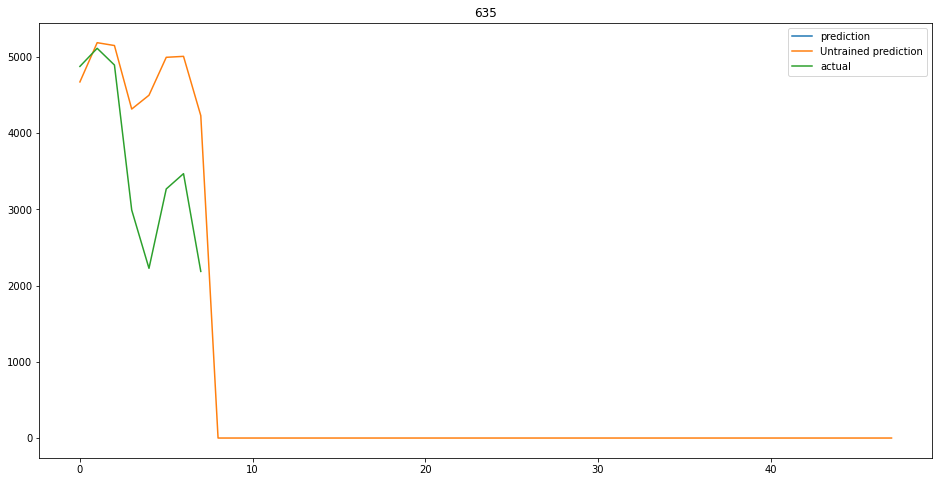

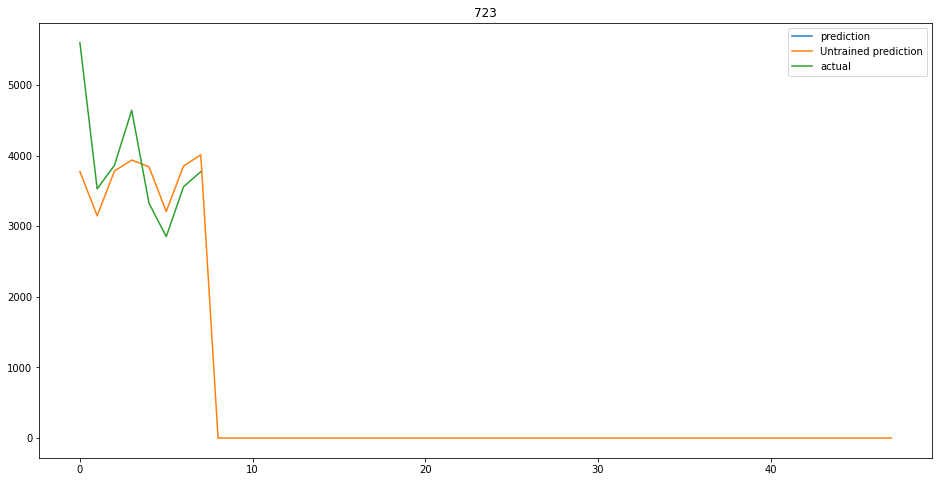

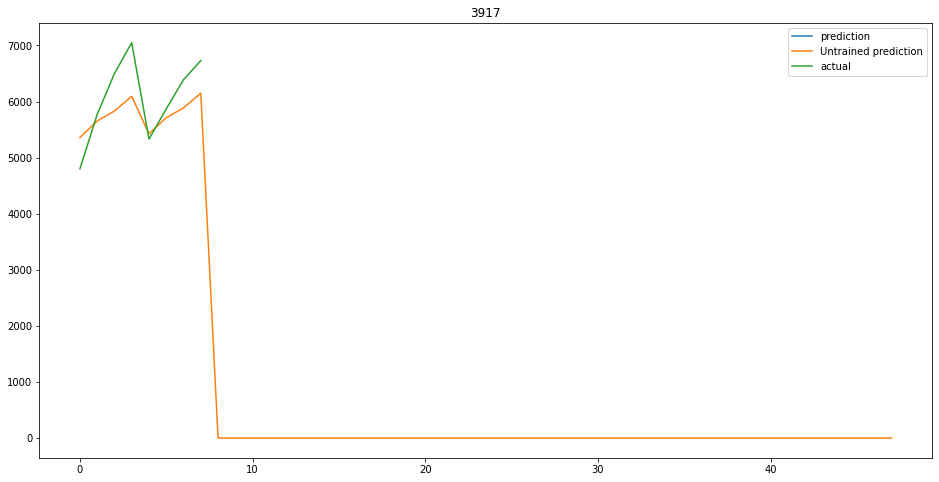

In [ ]:
net_untrained = Dense_net(42,9)
plt.rcParams["figure.figsize"] = (16,8)
def plot_some_forecast_and_actuals(net, n_plots):
    
    for i in random.sample(range(5000), k=n_plots): 
      
      inputs, forecasts, actuals, mask = feature_extractor(meta_train.iloc[[i]], "m", "minmax")
      y_pred = net(inputs).unsqueeze(2)
      y_pred_2 = net_untrained(inputs).unsqueeze(2)
      
      #print("trained", y_pred)
      #print("untrained", y_pred_2)

      
      method_forecast_tup = []

      predictions = torch.matmul(forecasts, y_pred).squeeze(2)
      predictions_un = torch.matmul(forecasts, y_pred_2).squeeze(2)

      plt.title(i)
      plt.plot(predictions.detach().numpy()[0], label="prediction")
      plt.plot(predictions_un.detach().numpy()[0], label="Untrained prediction")
      plt.plot(actuals.detach().numpy()[0], label="actual")
      plt.legend()
      plt.show()

plot_some_forecast_and_actuals(net, 3)